### A completar por el participante

In [1]:
punto_de_corte = 0.11395457979170637
criterion = "gini" #“gini”, “entropy”, “log_loss”
max_depth = 26
min_samples_split = 356
min_samples_leaf = 375

In [2]:
random_state = 777

### Importamos los paquetes necesarios

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  

from sklearn.metrics import confusion_matrix
from sklearn import tree

### Carga de datos adicionales sobre las cervezas:
* primera fecha de review
* ultima fecha de review 
* contenido alcoholico 
* disponibilidad (resta, en días, entre la ultima fecha de review y la primera fecha de review)

In [4]:
directorio_data = '../data/'
dataset_completo_file = directorio_data + 'beer_reviews.csv'
df_extra_info_dataset = pd.read_csv(dataset_completo_file)[['beer_beerid', 'review_time']]
df_extra_info_dataset['review_date'] = pd.to_datetime(pd.to_datetime(df_extra_info_dataset['review_time'],unit='s')).dt.date
df_extra_info_dataset.head()
df_extra_info_dataset = df_extra_info_dataset.groupby(['beer_beerid']).agg(
    min_review_date = pd.NamedAgg(column='review_date', aggfunc='min'),
    max_review_date = pd.NamedAgg(column='review_date', aggfunc='max')
).reset_index()

df_extra_info_dataset['disponibilidad'] = (df_extra_info_dataset['max_review_date'] - df_extra_info_dataset['min_review_date']) / np.timedelta64(1, 'D')

df_extra_info_dataset.head()

,beer_beerid,min_review_date,max_review_date,disponibilidad
0,3,2002-04-17,2003-03-17,334.0
1,4,2002-04-05,2005-03-21,1081.0
2,5,2001-07-08,2012-01-01,3829.0
3,6,2001-03-02,2012-01-02,3958.0
4,7,2001-10-19,2011-12-31,3725.0


## Zona de Feature engineering y filtrado

In [5]:
def feature_engineering_agregar_dispnibilidad(df):
    df_output = df.copy()
    
    df_output = pd.merge(left=df_output, right=df_extra_info_dataset, left_on='beer_beerid', right_on='beer_beerid')
    
    return df_output

def feature_engineering_total(df):
    df_output = df.copy()

    df_output['review_total'] = (df['review_overall'] + df['review_aroma'] + df['review_appearance'] + df['review_palate'] + df['review_taste'])
    
    return df_output

def feature_engineering_relacion_al_overall(df):
    df_output = df.copy()
    
    df_output['relacion_overall_aroma'] = df_output['review_aroma']/df['review_overall']
    df_output['relacion_overall_palate'] = df_output['review_palate']/df['review_overall']
    
    return df_output

def filtering_1(df):
    df_output = df
    return df_output

### Carga de datos

In [6]:
x_training_file = directorio_data + 'x_traininig.csv'
y_training_file = directorio_data + 'y_traininig.csv'

x_testing_file = directorio_data + 'x_testing.csv'
y_testing_file = directorio_data + 'y_testing.csv'

In [7]:
df_x_training_validacion = pd.read_csv(x_training_file)
df_y_training_validacion = pd.read_csv(y_training_file)

df_x_testing = pd.read_csv(x_testing_file)
df_y_testing = pd.read_csv(y_testing_file)

### Aplicamos las funciones de feature engineering a los datasets de training y testing

In [8]:
funciones = [
    "feature_engineering_agregar_dispnibilidad",
    "feature_engineering_total",
    "feature_engineering_relacion_al_overall"
]

df_x_training_validacion_fe = df_x_training_validacion.copy()
df_x_testing_fe = df_x_testing.copy()

for funcion in funciones:
    #¿es una función de feature engineering?
    if(funcion.startswith('feature_engineering_')):
       long_inicial_x_training_fe = len(df_x_training_validacion_fe)
       df_x_training_validacion_fe = locals()[funcion](df_x_training_validacion_fe)
       long_final_x_training_fe = len(df_x_training_validacion_fe)
       if(long_inicial_x_training_fe != long_final_x_training_fe):
           raise Exception("Se están eliminando registros del dataset de training en una funcion de feature engineering")
       
       
       long_inicial_x_testing_fe = len(df_x_testing_fe)
       df_x_testing_fe = locals()[funcion](df_x_testing_fe)
       long_final_x_testing_fe = len(df_x_testing_fe)
       if(long_inicial_x_testing_fe != long_final_x_testing_fe):
           raise Exception("Se están eliminando registros del dataset de testing en una funcion de feature engineering")
        
    #¿es una función de filtrado?
    elif(funcion.startswith('filtering_')):
       df_x_training_validacion_fe = locals()[funcion](df_x_training_validacion_fe)
           

In [9]:
df_x_training_validacion_fe.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_total,relacion_overall_aroma,relacion_overall_palate
0,7377,3.250000,3.000,3.000000,3.250000,3.250000,5.2,2003-04-20,2006-02-27,1044.0,15.750000,0.923077,1.000000
1,21753,4.150000,4.175,4.400000,4.125000,4.125000,4.2,2005-01-30,2011-07-05,2347.0,20.975000,1.006024,0.993976
2,5330,4.000000,4.000,4.000000,4.000000,4.500000,8.0,2002-08-07,2002-08-07,0.0,20.500000,1.000000,1.000000
3,67188,4.125000,3.875,3.750000,4.125000,4.000000,6.0,2011-03-14,2011-04-19,36.0,19.875000,0.939394,1.000000
4,16542,4.208333,3.750,4.333333,4.083333,4.083333,6.7,2004-04-26,2011-01-26,2466.0,20.458333,0.891089,0.970297


In [10]:
df_x_testing_fe.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_total,relacion_overall_aroma,relacion_overall_palate
0,10364,3.751534,3.030675,3.257669,3.266871,3.401840,4.6,2003-07-04,2012-01-08,3110.0,16.708589,0.807850,0.870809
1,18518,3.818182,3.727273,3.545455,3.681818,3.818182,7.0,2004-07-05,2011-11-24,2698.0,18.590909,0.976190,0.964286
2,16278,3.071429,2.928571,3.500000,3.214286,3.142857,4.0,2005-11-04,2009-01-02,1155.0,15.857143,0.953488,1.046512
3,11087,2.625000,2.750000,3.250000,3.375000,2.750000,5.0,2005-02-21,2006-07-10,504.0,14.750000,1.047619,1.285714
4,17042,4.000000,3.500000,3.000000,4.000000,4.000000,4.8,2004-04-10,2004-04-10,0.0,18.500000,0.875000,1.000000


### Dejamos solo las columnas que queremos

In [11]:
# Las columnas que deseamos mantener
columnas = [
    "review_overall",
    #"review_aroma",
    #"review_appearance",
    "review_palate",
    #"review_taste",
    "beer_abv",
    #"potencia_alcoholica",
    #"potencia_alcoholica_muy_baja",
    #"potencia_alcoholica_baja",
    #"potencia_alcoholica_media",
    #"potencia_alcoholica_fuerte",
    #"potencia_alcoholica_muy_fuerte",
    #"review_promedio",
    "review_total",
    'relacion_overall_aroma',
    #'relacion_overall_appearance',
    'relacion_overall_palate',
    #'relacion_overall_taste',
    'disponibilidad'
]

In [12]:
df_x_training_validacion_tmp = df_x_training_validacion_fe[columnas]
df_x_testing_tmp = df_x_testing_fe[columnas]

### Entrenamos el modelo

In [14]:
clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
            random_state = random_state
        )
_ = clf.fit(df_x_training_validacion_tmp, df_y_training_validacion)

### Ejecutamos el modelo contra testing

In [15]:
y_validacion_pred = clf.predict_proba(df_x_testing_tmp)
df_y_validacion_pred_proba = pd.DataFrame(y_validacion_pred, columns = ['NO_prob', 'SI_prob'])
df_y_validacion_pred_proba['prediccion'] = 'NO'
df_y_validacion_pred_proba.loc[df_y_validacion_pred_proba['SI_prob']>punto_de_corte, 'prediccion'] = 'SI'
df_y_validacion_pred_proba

,NO_prob,SI_prob,prediccion
0,0.992537,0.007463,NO
1,0.963470,0.036530,NO
2,1.000000,0.000000,NO
3,1.000000,0.000000,NO
4,1.000000,0.000000,NO
...,...,...,...
9795,1.000000,0.000000,NO
9796,1.000000,0.000000,NO
9797,0.962264,0.037736,NO
9798,1.000000,0.000000,NO


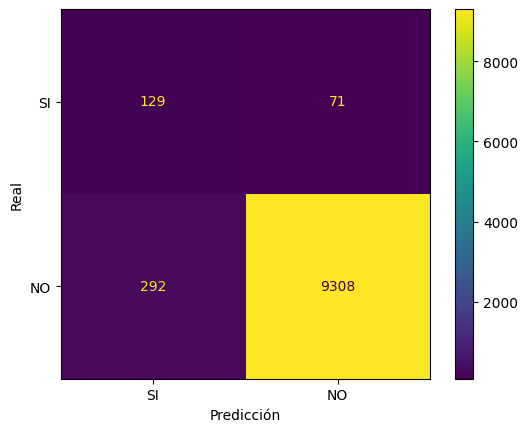

In [16]:
cm = confusion_matrix(df_y_testing, df_y_validacion_pred_proba['prediccion'], labels=['SI', 'NO'])
true_positives = cm[0,0]
true_negatives = cm[1,1]
false_positives = cm[1, 0]
false_negatives = cm[0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SI', 'NO'])
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [17]:
metrica_negocio = ((4000*true_positives) - (500*false_positives))/(true_positives + false_negatives)
metrica_negocio

1850.0